## 1. Generate detailed list of requirements from reference logo image

We are using GPT-4o and a reference logo image to prompt it to generate a detailed list of requirements for the logo.
The requirements are created as a list of Yes/No question about the logo.

These requirements will be used downstream as a checklist to verify whether a new logo is compliant with the requirements. 

- Create an Azure OpenAI resource in your region of choice
- Go to Azure OpenAI Studio and create a GPT-4o deployment in your Azure OpenAI Resource
- Create a .env file containing your credentials AZURE_OPENAI_ENDPOINT, AZURE_OPENAI_API_KEY, AZURE_OPENAI_MODEL. 

In [ ]:
from openai import AzureOpenAI
import os
from dotenv import load_dotenv
import base64
import json

load_dotenv()

client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version="2024-02-01",
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    )

# Function to convert image to base64  
def open_image_to_base64(file_path):  
    with open(file_path, "rb") as image_file:  
        image_data = image_file.read()  
        base64_data = base64.b64encode(image_data).decode("utf-8")  
        base64_url = f"data:image/jpeg;base64,{base64_data}"  
        return base64_url
    
def create_requirements(prompt, reference_img, client):
  response = client.chat.completions.create(
    model=os.getenv("AZURE_OPENAI_MODEL"),
    messages=[
      {
        "role": "user",
        "content": [
          {"type": "text", "text": prompt},
          {
            "type": "image_url",
            "image_url": {
              "url": reference_img,
            },
          }
        ],
      }
    ],
    max_tokens=300,
  )
  return response.choices[0]
    
requirements_prompt = """
You are an AI creative designer assistant
Your are presented with the image of a logo, your role is to analyze the image and provide a list of requirements that can be used to check whether a logo is compliant with the brand.
You should be as detailed as possible, describe every part of the logo including shape, text, border, colors etc

## You must pay extra attention to the border around the logo and the border thickness (thin, thick etc) and color

Return the list of requirements for the logo as a bullet list in the form of questions
only return the requirements, do not return any other information
"""

reference_img = open_image_to_base64("./nba_logo_reference.png")

reqs = create_requirements(requirements_prompt, reference_img, client).message.content
# Save the requirements in a JSON file
logo_requirements = {"nba": reqs}

# Check if the file already exists
if os.path.exists("logo_requirements.json"):
  with open("logo_requirements.json", "r") as json_file:
    existing_data = json.load(json_file)
  existing_data.update(logo_requirements)
  with open("logo_requirements.json", "w") as json_file:
    json.dump(existing_data, json_file, indent=4)
else:
  with open("logo_requirements.json", "w") as json_file:
    json.dump(logo_requirements, json_file, indent=4)

## 2. Detect and extract logos in candidate image

- Train a Custom Vision object detection model on a diverse set of images of the logo(s). The images can be of compliant or non-compliant logo.
- Deploy an Azure AI Custom Vision object detection model trained on at least 15 images of the logo
- Copy the Endpoint URL and API key to the .env file

In [ ]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from io import BytesIO

In [ ]:
# retrieve environment variables
CUSTOM_VISION_ENDPOINT = os.getenv("CUSTOM_VISION_ENDPOINT")
CUSTOM_VISION_KEY = os.getenv("CUSTOM_VISION_PREDICTION_KEY")

prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": CUSTOM_VISION_KEY})
predictor = CustomVisionPredictionClient(CUSTOM_VISION_ENDPOINT, prediction_credentials)

prediction_threshold = 0.4

	nba: 93.41% bbox.left = 0.58, bbox.top = 0.49, bbox.width = 0.07, bbox.height = 0.26
	nba: 92.37% bbox.left = 0.84, bbox.top = 0.49, bbox.width = 0.07, bbox.height = 0.25
	nba: 78.49% bbox.left = 0.28, bbox.top = 0.39, bbox.width = 0.10, bbox.height = 0.31


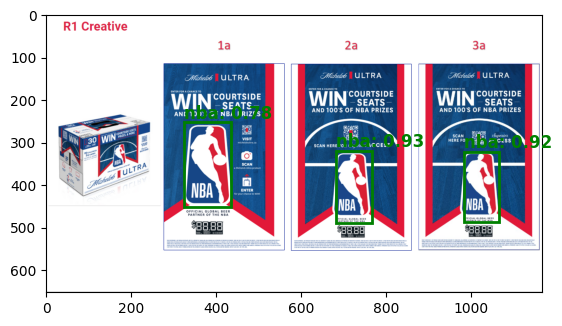

In [ ]:

# Now there is a trained endpoint that can be used to make a prediction
with open(os.path.join("/home/vhoudebine/projects/azure-image-segmentation/logo_compliance_test/valid_logo_with_different_oreientation.png"), "rb") as image_contents:
    results = predictor.detect_image("4953d734-f467-4f06-8548-41234a26c935", "Iteration1", image_contents)


# Open the image
image = Image.open(image_contents.name)
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Add bounding boxes
for prediction in results.predictions:
    if prediction.probability > prediction_threshold:
        print("\t" + prediction.tag_name + ": {0:.2f}% bbox.left = {1:.2f}, bbox.top = {2:.2f}, bbox.width = {3:.2f}, bbox.height = {4:.2f}".format(prediction.probability * 100, prediction.bounding_box.left, prediction.bounding_box.top, prediction.bounding_box.width, prediction.bounding_box.height))

        rect = patches.Rectangle(
            (prediction.bounding_box.left * image.width, prediction.bounding_box.top * image.height),
            prediction.bounding_box.width * image.width,
            prediction.bounding_box.height * image.height,
            linewidth=2, edgecolor='g', facecolor='none'
        )
        ax.add_patch(rect)
        plt.text(
            prediction.bounding_box.left * image.width,
            prediction.bounding_box.top * image.height - 10,
            f"{prediction.tag_name}: {prediction.probability:.2f}",
            color='green', fontsize=12, weight='bold'
        )

plt.show()

## 3. Verify the compliance of each logo against the set of requirements

We will use GPT-4o to analyze the extracted logo against the list of requirements and decide whether the extracted logo is compliant.

In [ ]:
def analyze_logo(compliance_prompt, image_1,client):
  response = client.chat.completions.create(
    model=os.getenv("AZURE_OPENAI_MODEL"),
    response_format={ "type": "json_object" },
    messages=[
      {
        "role": "user",
        "content": [
          {"type": "text", "text": compliance_prompt},
          
          {
            "type": "image_url",
            "image_url": {
              "url": image_1,
              "detail": "high"
            },
          }
        ],
      }
    ],
    max_tokens=300,
  )
  return response.choices[0]

def requirements_lookup(logo_name):
  with open("logo_requirements.json", "r") as json_file:
    data = json.load(json_file)
  return data[logo_name]

def generate_compliance_prompt(requirements):
  return f'''You are a creative designer assistant tasked with ensuring logos are compliant with the brand.
You are presented with an image of a logo and a list of requirements that can be used to check whether a logo is compliant with the brand.

# Analyze the logo and determine if it is compliant with the brand.
# You must ignore anything that is around the logo like text etc. You must focus on the logo only

## Important: the logo can be rotated, flipped or in any orientation, a flipped logo is still compliant if it meets the requirements

# You must consider the following questions when analyzing the logo:
{requirements}

# Answer each question with True or False
# If any answer is False, the logo is not compliant

## Your response should be a JSON with the following structure:
{{"compliant":True, "explanation":"summary of the explanation", "questions": "answers to each question"}}
'''


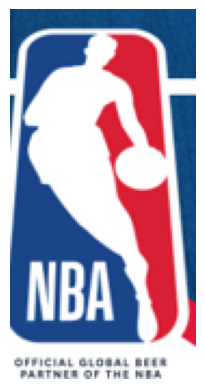

{'compliant': True, 'explanation': 'The logo meets all the brand requirements.', 'questions': {'Is the logo in a vertically oriented rectangular shape with rounded corners?': True, 'Is there a silhouette of a basketball player in white positioned in the center?': True, 'Is the background color on the left side of the logo blue?': True, 'Is the background color on the right side of the logo red?': True, "Is there a 'NBA' text at the bottom of the logo in white?": True, "Is the font of the 'NBA' text bold and in capital letters?": True, 'Is there a border around the logo?': True, 'Is the border color white?': True, 'Is the border thickness proportionate to the logo, generally thin?': True, 'Do the colors follow the brand’s official color palette (red, blue, white)?': True, 'Is the overall design clean, with no additional elements or distortions?': True}, 'logo_name': 'nba'}


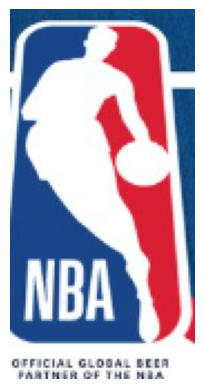

{'compliant': True, 'explanation': 'The logo meets all the specified brand requirements.', 'questions': {'Is the logo in a vertically oriented rectangular shape with rounded corners?': True, 'Is there a silhouette of a basketball player in white positioned in the center?': True, 'Is the background color on the left side of the logo blue?': True, 'Is the background color on the right side of the logo red?': True, "Is there a 'NBA' text at the bottom of the logo in white?": True, "Is the font of the 'NBA' text bold and in capital letters?": True, 'Is there a border around the logo?': True, 'Is the border color white?': True, 'Is the border thickness proportionate to the logo, generally thin?': True, 'Do the colors follow the brand’s official color palette (red, blue, white)?': True, 'Is the overall design clean, with no additional elements or distortions?': True}, 'logo_name': 'nba'}


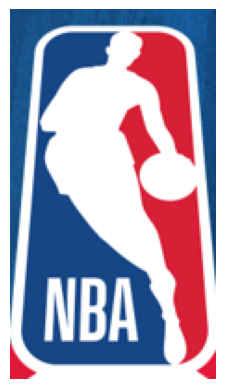

{'compliant': True, 'explanation': 'The logo meets all the specified brand requirements.', 'questions': {'Is the logo in a vertically oriented rectangular shape with rounded corners?': True, 'Is there a silhouette of a basketball player in white positioned in the center?': True, 'Is the background color on the left side of the logo blue?': True, 'Is the background color on the right side of the logo red?': True, "Is there a 'NBA' text at the bottom of the logo in white?": True, "Is the font of the 'NBA' text bold and in capital letters?": True, 'Is there a border around the logo?': True, 'Is the border color white?': True, 'Is the border thickness proportionate to the logo, generally thin?': True, 'Do the colors follow the brand’s official color palette (red, blue, white)?': True, 'Is the overall design clean, with no additional elements or distortions?': True}, 'logo_name': 'nba'}


In [ ]:
buffer = 0  # Buffer in pixels

for prediction in results.predictions:
    if prediction.probability > prediction_threshold:
        buffered = BytesIO()

        left = max(0, int(prediction.bounding_box.left * image.width) - buffer)
        top = max(0, int(prediction.bounding_box.top * image.height) - buffer)
        right = min(image.width, int((prediction.bounding_box.left + prediction.bounding_box.width) * image.width) + buffer)
        bottom = min(image.height, int((prediction.bounding_box.top + prediction.bounding_box.height) * image.height) + buffer)
        
        cropped_image = image.crop((left, top, right, bottom))
        cropped_image.convert('RGB').save(buffered, format="JPEG")
        
        # Convert the cropped image to base64
        img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
        base64_url = f"data:image/jpeg;base64,{img_str}" 

        # Display the cropped image
        plt.imshow(cropped_image)
        plt.axis('off')  # Hide axes
        plt.show()


        # Look up the requirements for the logo and inject them into the prompt
        reqs = requirements_lookup(prediction.tag_name)
        compliance_prompt = generate_compliance_prompt(reqs)
        
        try:
            logo_compliance = analyze_logo(compliance_prompt, base64_url, client).message.content
            compliance_dict = json.loads(logo_compliance)
            compliance_dict["logo_name"] = prediction.tag_name
            print(compliance_dict)
        except Exception as e:
            print(e)
            continue
        
